<a href="https://colab.research.google.com/github/mralamdari/Machine_Learning_Projects/blob/main/Food_101_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Jan 15 04:03:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#10% of dataset


In [ ]:
# # Get data (10% of labels)
# import zipfile

# # Download data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# # Unzip the downloaded file
# zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
# zip_ref.extractall()
# zip_ref.close()

# How many images in each folder?

# Walk through 10 percent data directory and list number of files
# for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
#   print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


# # Setup data inputs
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# IMAGE_SHAPE = (224, 224)
# BATCH_SIZE = 32

# train_dir = "10_food_classes_10_percent/train/"
# test_dir = "10_food_classes_10_percent/test/"

# train_datagen = ImageDataGenerator(rescale=1/255.)
# test_datagen = ImageDataGenerator(rescale=1/255.)

# print("Training images:")
# train_data_10_percent = train_datagen.flow_from_directory(train_dir,
#                                                target_size=IMAGE_SHAPE,
#                                                batch_size=BATCH_SIZE,
#                                                class_mode="categorical")

# print("Testing images:")
# test_data = train_datagen.flow_from_directory(test_dir,
#                                               target_size=IMAGE_SHAPE,
#                                               batch_size=BATCH_SIZE,
#                                               class_mode="categorical")




#Data

##Import Data

data source is [FOOD-101](https://colab.research.google.com/github/theimgclist/examples/blob/MultiClassTF2.0/community/en/multi_class_classification/food_classifier.ipynb#scrollTo=7wJ_OH1DQyrd)

data size = 5 GB

data load time = 3.26

In [ ]:
tf.keras.utils.get_file('food-101.tar.gz', 'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz', cache_subdir='/content', extract=True, archive_format='tar', cache_dir=None)

4996292608/4996278331 [==============================] - 167s 0us/step


'/content/food-101.tar.gz'

In [ ]:
len(os.listdir('food-101/images'))

101

##Visualize the data
###showing one image per class from 101 classes


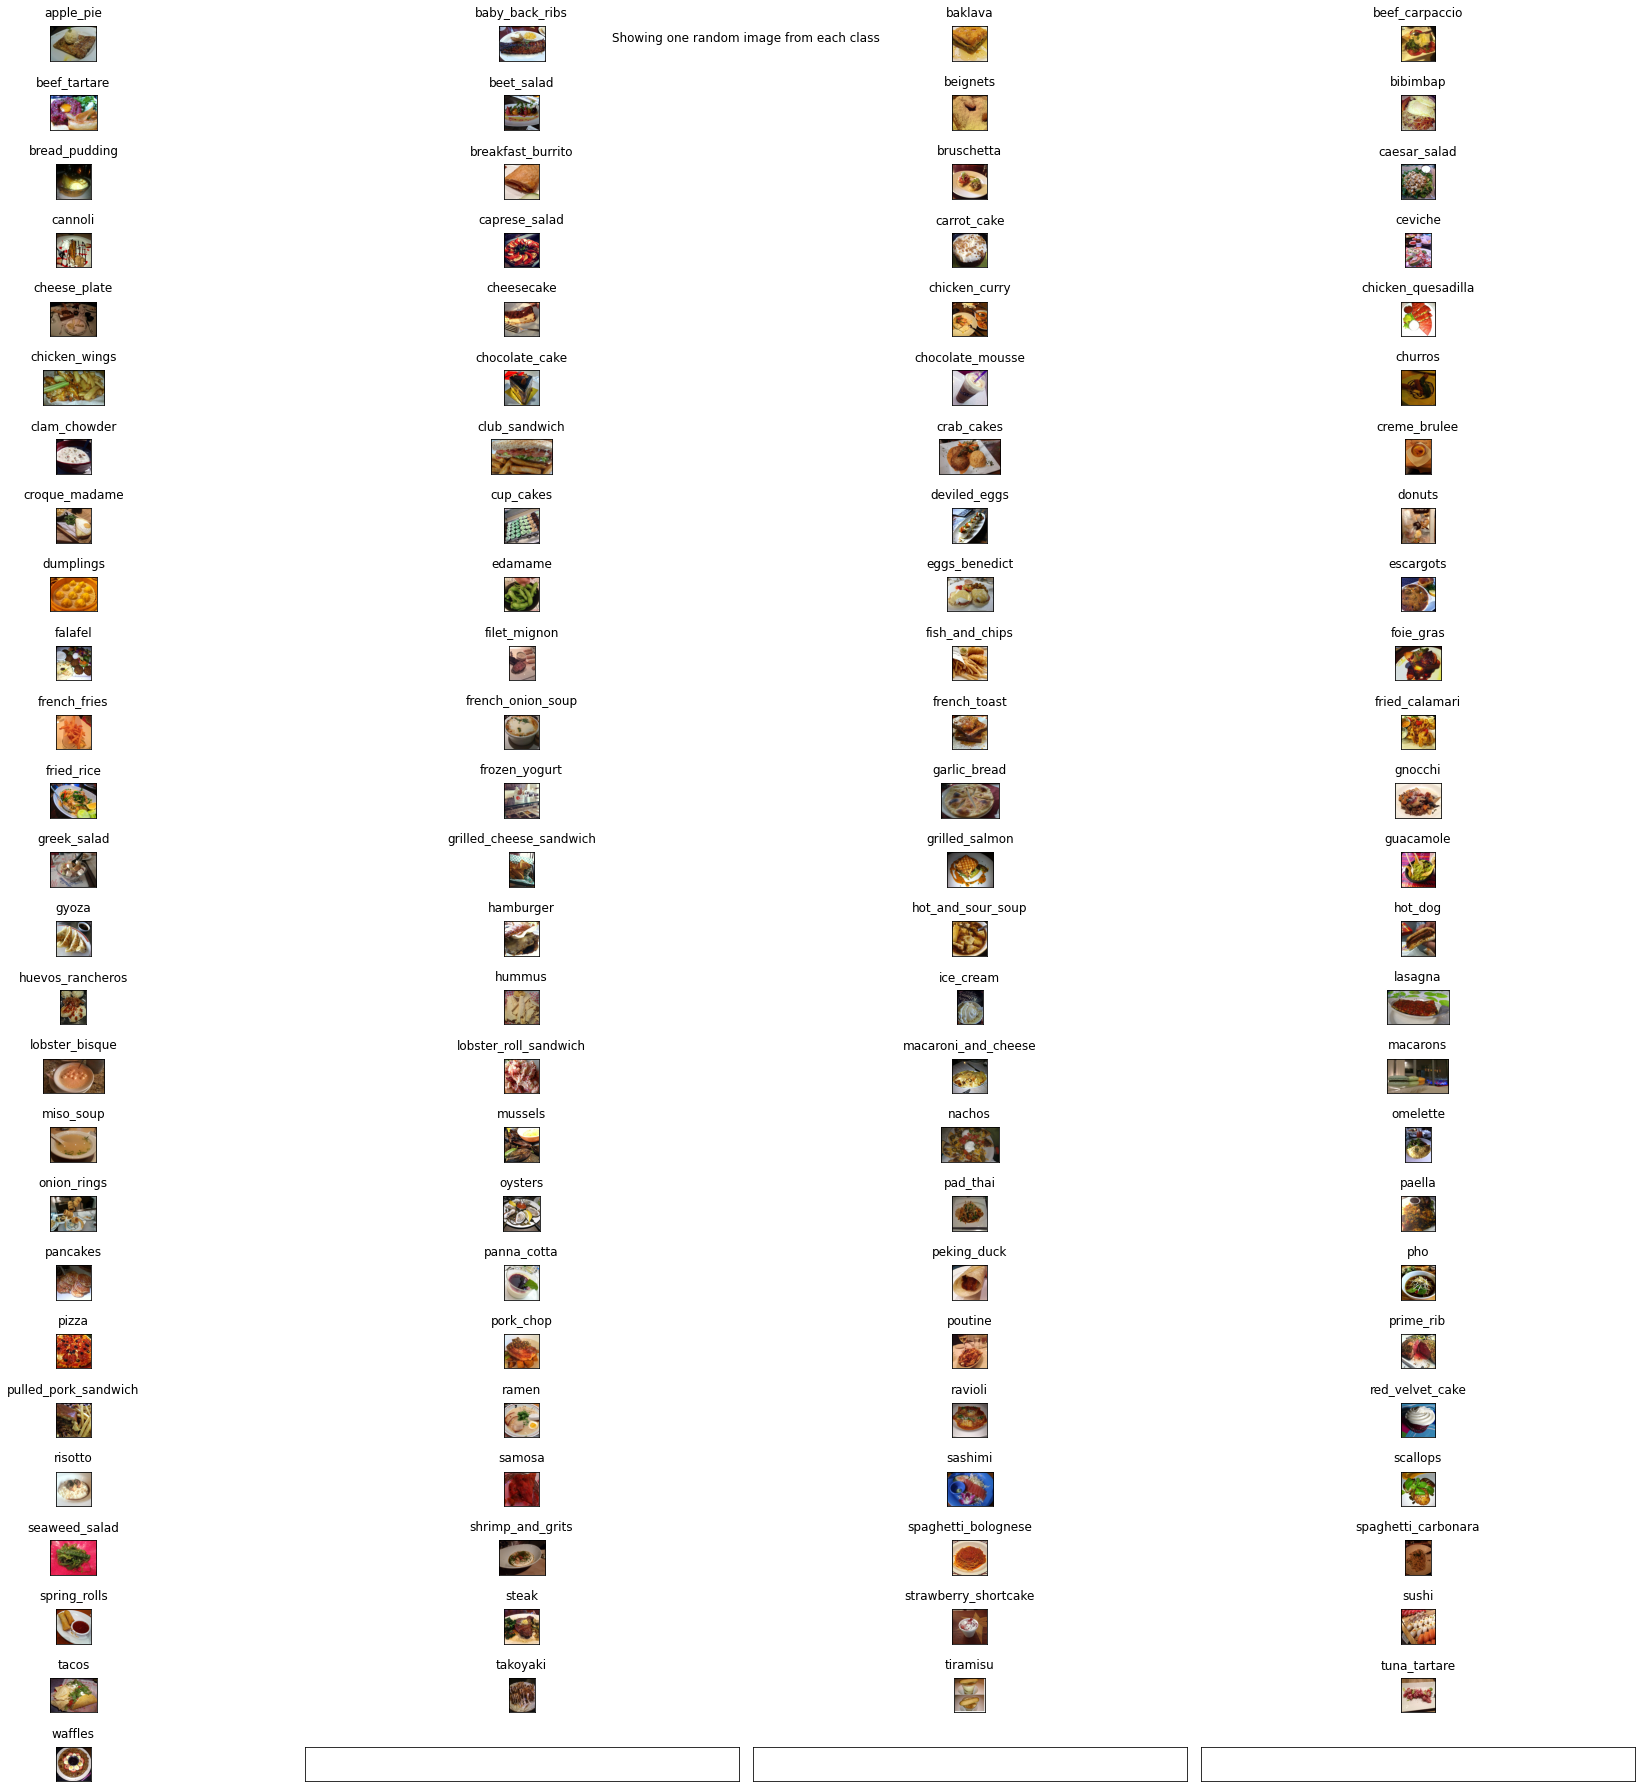

In [ ]:
rows = 26
cols = 4
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class")
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) 
    food_selected_random = np.random.choice(food_selected_images)
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

##Split data into train and test datasets

###At first we use 0.1 of data as Train Data
###and use 0.9 of data as Validation Data
####Becuase Here our problem is to find the best classifier then, we will use more training data

In [ ]:
dir = 'food-101/images'

idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, validation_split=0.2)

train_data = idg.flow_from_directory(directory=dir,
                        target_size=(224, 224), 
                        batch_size=32,
                        class_mode='categorical',
                        subset='training',
                        shuffle=True)


val_data = idg.flow_from_directory(directory=dir,
                        target_size=(224, 224), 
                        batch_size=32,
                        class_mode='categorical',
                        subset='validation',
                        shuffle=True,)

Found 80800 images belonging to 101 classes.
Found 20200 images belonging to 101 classes.


#Model

In [ ]:
import tensorflow_hub
def create_model(model_url, num_classes=101):
  feature_extracter_layer = tensorflow_hub.KerasLayer(model_url,
                                                      trainable=False,
                                                      name='feature_extraction_layer',
                                                      input_shape=(224, 224, 3), dtype='float32')
  
  model = tf.keras.Sequential([
    feature_extracter_layer,
    tf.keras.layers.Dense(num_classes,
                    activation='softmax',
                    name='output_layer', dtype='float32')])  
  return model

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

##ResNet V2 50

26min

In [ ]:
# resnet_v2_50_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/classification/5'    #normal model
resnet_v2_50_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'      #Pre-Trained model

resnet_model = create_model(resnet_v2_50_url)

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

resnet_history = resnet_model.fit(train_data,
                                  epochs=20,
                                  steps_per_epoch=len(train_data)//10,
                                  validation_data=val_data,
                                  validation_steps=len(val_data)//10)

Epoch 1/20
252/252 [==============================] - 98s 336ms/step - loss: 3.1088 - accuracy: 0.2888 - val_loss: 2.3750 - val_accuracy: 0.4127
Epoch 2/20
252/252 [==============================] - 76s 301ms/step - loss: 2.2804 - accuracy: 0.4472 - val_loss: 2.1939 - val_accuracy: 0.4593
Epoch 3/20
252/252 [==============================] - 80s 318ms/step - loss: 2.0635 - accuracy: 0.4942 - val_loss: 2.1390 - val_accuracy: 0.4757
Epoch 4/20
252/252 [==============================] - 74s 292ms/step - loss: 1.9492 - accuracy: 0.5202 - val_loss: 2.1153 - val_accuracy: 0.4955
Epoch 5/20
252/252 [==============================] - 77s 306ms/step - loss: 1.8191 - accuracy: 0.5476 - val_loss: 1.9801 - val_accuracy: 0.5069
Epoch 6/20
252/252 [==============================] - 70s 276ms/step - loss: 1.8080 - accuracy: 0.5484 - val_loss: 2.0140 - val_accuracy: 0.5273
Epoch 7/20
252/252 [==============================] - 76s 300ms/step - loss: 1.7643 - accuracy: 0.5629 - val_loss: 2.0424 - val_ac

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.ResNet50V2(include_top=False, )

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9),
              # optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data,
                                 epochs=10,
                                 steps_per_epoch=len(train_data),
                                 validation_data=val_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=len(val_data))

Shape after base_model: (None, 7, 7, 2048)
After GlobalAveragePooling2D(): (None, 2048)
Epoch 1/10
2525/2525 [==============================] - 665s 262ms/step - loss: 2.9663 - accuracy: 0.3187 - val_loss: 2.3195 - val_accuracy: 0.4435
Epoch 2/10
2525/2525 [==============================] - 666s 264ms/step - loss: 2.1006 - accuracy: 0.4868 - val_loss: 2.0662 - val_accuracy: 0.4925
Epoch 3/10
2525/2525 [==============================] - 664s 263ms/step - loss: 1.8864 - accuracy: 0.5328 - val_loss: 1.9609 - val_accuracy: 0.5160
Epoch 4/10
2525/2525 [==============================] - 668s 264ms/step - loss: 1.7612 - accuracy: 0.5598 - val_loss: 1.9036 - val_accuracy: 0.5282
Epoch 5/10
2525/2525 [==============================] - 675s 267ms/step - loss: 1.6721 - accuracy: 0.5806 - val_loss: 1.8645 - val_accuracy: 0.5349
Epoch 6/10
2525/2525 [==============================] - 662s 262ms/step - loss: 1.6015 - accuracy: 0.5968 - val_loss: 1.8363 - val_accuracy: 0.5424
Epoch 7/10
2525/2525 [==

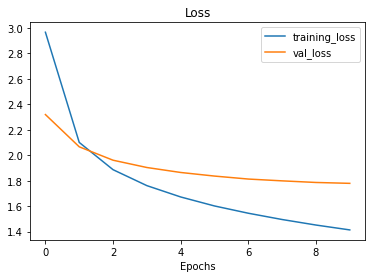

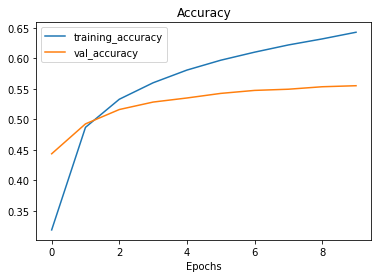

In [ ]:
plot_loss_curves(history_10_percent)

In [ ]:
model_0.evaluate(train_data)

2525/2525 [==============================] - 553s 219ms/step - loss: 1.3542 - accuracy: 0.6583


[1.3541723489761353, 0.6583291888237]

In [ ]:
model_0.evaluate(val_data)

632/632 [==============================] - 137s 216ms/step - loss: 1.7791 - accuracy: 0.5550


[1.7791334390640259, 0.5550000071525574]

In [ ]:
model_0.save('/content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/resnet_model_0.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


##Inception V3

####26min

In [ ]:
# inception_v3_url = 'https://tfhub.dev/google/imagenet/inception_v3/classification/5'
inception_v3_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

inception_model = create_model(inception_v3_url)
inception_model.compile(loss='categorical_crossentropy', 
                     optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                     metrics=['accuracy'])
inception_history_1 = inception_model.fit(train_data,
                                        epochs=20,
                                        steps_per_epoch=len(train_data),
                                        validation_data=val_data,
                                        validation_steps=len(val_data))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
2244/2525 [=========================>....] - ETA: 1:05 - loss: 3.0374 - accuracy: 0.3942

In [ ]:
# inception_model.save('/content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/The_Best_inception_1.h5')

tf.keras.models.save_model(inception_model, '/content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/The_Best_inception_1')
# tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/The_Best_inception_1')

In [ ]:
acacaeczdv
 hvkhkvcvddfnlvsfvbsc,lnfnklfgd
 fdmfklvfklnfklnfl kfds
 asrlmsamlvsrs

In [ ]:
fine_tune_epochs = 15

inception_model.trainable = True

# Freeze all layers except for the
for layer in inception_model.layers[:-3]:
  layer.trainable = False

inception_model.compile(loss='categorical_crossentropy', 
                     optimizer=tf.keras.optimizers.Adam(lr=0.00003),
                     metrics=['accuracy'])

inception_history_2 = inception_model.fit(train_data,
                                epochs=fine_tune_epochs,
                                steps_per_epoch=len(train_data),
                                validation_data=val_data,
                                validation_steps=len(val_data), 
                                initial_epoch=inception_history_1.epoch[-1]+1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 11/15
2525/2525 [==============================] - 1454s 572ms/step - loss: 0.2147 - accuracy: 0.9833 - val_loss: 1.0957 - val_accuracy: 0.8035
Epoch 12/15
2525/2525 [==============================] - 1443s 572ms/step - loss: 0.1979 - accuracy: 0.9880 - val_loss: 1.0874 - val_accuracy: 0.8076
Epoch 13/15
2431/2525 [===========================>..] - ETA: 49s - loss: 0.1850 - accuracy: 0.9916

In [ ]:
# inception_model.save('/content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/The_Best_inception_5.h5')
# tf.keras.models.save_model(inception_model, '/content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/The_Best_inception_5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/The_Best_inception_3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/The_Best_inception_3/assets


In [ ]:
print(inception_model.evaluate(val_data), inception_model.evaluate(train_data))


2525/2525 [==============================] - 489s 194ms/step - loss: 0.2372 - accuracy: 0.9733
[1.1597199440002441, 0.7719802260398865] [0.23715047538280487, 0.9733291864395142]


10
15
[0.4087376296520233, 0.5852227807044983, 0.6256188154220581, 0.6498391032218933, 0.6661633849143982, 0.6802722811698914, 0.6913985013961792, 0.7010767459869385, 0.710928201675415, 0.7162128686904907, 0.7073267102241516, 0.8114851713180542, 0.864653468132019, 0.9010148644447327, 0.9227970242500305]


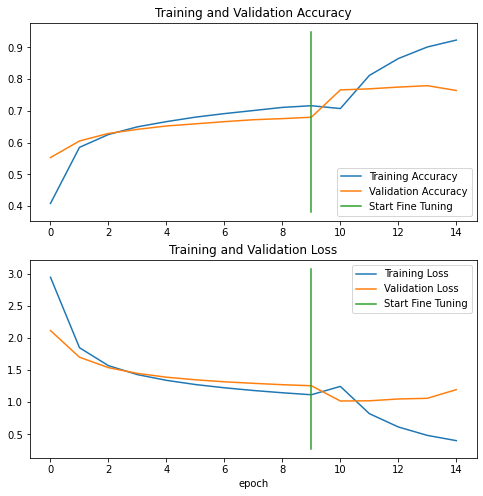

In [ ]:
compare_historys(original_history=inception_history_1,
                 new_history=inception_history_2,
                 initial_epochs=10)

In [ ]:
print(inception_model.evaluate(val_data), inception_model.evaluate(train_data))    #lr=0.1

2525/2525 [==============================] - 492s 195ms/step - loss: 1.7215 - accuracy: 0.6452
[2.1396665573120117, 0.5934158563613892] [1.7214549779891968, 0.6451609134674072]


In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [ ]:
b1=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/The_Best_inception.h5')
b2=tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/The_Best_inception_2.h5')

OSError: ignored

#eeeeee


In [ ]:
print(inception_model.evaluate(val_data), inception_model.evaluate(train_data))    #lr=0.01

2525/2525 [==============================] - 518s 205ms/step - loss: 1.7215 - accuracy: 0.6452
[2.1396663188934326, 0.5934158563613892] [1.7214577198028564, 0.6451609134674072]


In [ ]:
print(inception_model.evaluate(val_data), inception_model.evaluate(train_data))    #lr=0.001

2525/2525 [==============================] - 565s 224ms/step - loss: 1.3766 - accuracy: 0.6520
[1.4690059423446655, 0.6293069124221802] [1.3766329288482666, 0.6520420908927917]


In [ ]:
print(inception_model.evaluate(val_data), inception_model.evaluate(train_data))    #lr=0.0001

2525/2525 [==============================] - 537s 213ms/step - loss: 2.6903 - accuracy: 0.4869
[2.708357334136963, 0.48034653067588806] [2.6902804374694824, 0.4869430661201477]


In [ ]:
print(inception_model.evaluate(val_data), inception_model.evaluate(train_data))    #lr=0.03

2525/2525 [==============================] - 473s 187ms/step - loss: 4.5845 - accuracy: 0.6065
[5.623514652252197, 0.5621287226676941] [4.584532260894775, 0.606522262096405]


In [ ]:
print(inception_model.evaluate(val_data), inception_model.evaluate(train_data))    #lr=0.003

2525/2525 [==============================] - 475s 188ms/step - loss: 1.2301 - accuracy: 0.6798
[1.428206443786621, 0.6327722668647766] [1.2300984859466553, 0.679777204990387]


In [ ]:
print(inception_model.evaluate(val_data), inception_model.evaluate(train_data))    #lr=0.0003

2525/2525 [==============================] - 476s 189ms/step - loss: 1.8237 - accuracy: 0.5898
[1.8608512878417969, 0.5797029733657837] [1.8236536979675293, 0.5897648334503174]


In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
# # Continue to train and fine-tune the model to our data
# # Freeze all layers except for the
# for layer in base_model.layers[:-10]:
#   layer.trainable = False

  
# fine_tune_epochs = initial_epochs + 5

# history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
#                                            epochs=fine_tune_epochs,
#                                            initial_epoch=history_10_percent_data_aug.epoch[-1],
#                                            validation_data=test_data,
#                                            validation_steps=int(0.25 * len(test_data)),
#                                            callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])



# # How did fine-tuning go with more data?
# compare_historys(original_history=inception_history_1,
#                  new_history=inception_history_2,
#                  initial_epochs=10)

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, )
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(101, activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)
model_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9),
              # optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9),
              metrics=["accuracy"])

history_10_percent = model_1.fit(train_data,
                                 epochs=20,
                                 steps_per_epoch=len(train_data)//10,
                                 validation_data=val_data,
                                 validation_steps=len(val_data)//10)

Epoch 1/20
252/252 [==============================] - 82s 305ms/step - loss: 3.3889 - accuracy: 0.2448 - val_loss: 2.7685 - val_accuracy: 0.3393
Epoch 2/20
252/252 [==============================] - 71s 282ms/step - loss: 2.5547 - accuracy: 0.3842 - val_loss: 2.4892 - val_accuracy: 0.3904
Epoch 3/20
252/252 [==============================] - 76s 300ms/step - loss: 2.4287 - accuracy: 0.4241 - val_loss: 2.3605 - val_accuracy: 0.4444
Epoch 4/20
252/252 [==============================] - 76s 300ms/step - loss: 2.2605 - accuracy: 0.4475 - val_loss: 2.4182 - val_accuracy: 0.4301
Epoch 5/20
252/252 [==============================] - 68s 270ms/step - loss: 2.2485 - accuracy: 0.4611 - val_loss: 2.4000 - val_accuracy: 0.4355
Epoch 6/20
252/252 [==============================] - 75s 298ms/step - loss: 2.1799 - accuracy: 0.4741 - val_loss: 2.3576 - val_accuracy: 0.4459
Epoch 7/20
252/252 [==============================] - 68s 271ms/step - loss: 2.1265 - accuracy: 0.4792 - val_loss: 2.3028 - val_ac

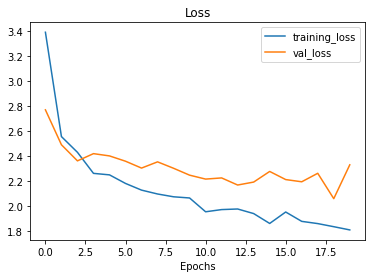

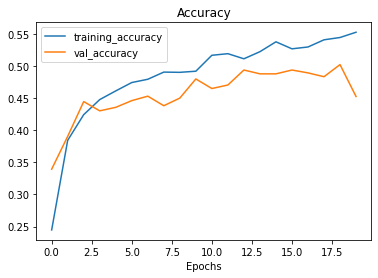

In [ ]:
plot_loss_curves(history_10_percent)

In [ ]:
model_1.evaluate(train_data)

2525/2525 [==============================] - 540s 214ms/step - loss: 1.8836 - accuracy: 0.5386


[1.8836169242858887, 0.5385891199111938]

In [ ]:
model_1.evaluate(val_data)
# model_0.save('/content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/resnet_model_0.h5')


632/632 [==============================] - 137s 217ms/step - loss: 2.3481 - accuracy: 0.4688


[2.3480637073516846, 0.4687623679637909]

##MobileNet V2

#####26min

In [ ]:
# mobilenet_v2_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5'

mobilenet_v2_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5'


mobilenet_model = create_model(mobilenet_v2_url)

mobilenet_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

mobilenet_history = mobilenet_model.fit(train_data, 
                                   epochs=20,
                                   steps_per_epoch=len(train_data)//10,
                                   validation_data=val_data,
                                   validation_steps=len(val_data)//10)

Epoch 1/20
252/252 [==============================] - 61s 224ms/step - loss: 3.0648 - accuracy: 0.3003 - val_loss: 2.3445 - val_accuracy: 0.4276
Epoch 2/20
252/252 [==============================] - 66s 262ms/step - loss: 2.1428 - accuracy: 0.4656 - val_loss: 2.0186 - val_accuracy: 0.4990
Epoch 3/20
252/252 [==============================] - 57s 228ms/step - loss: 1.9046 - accuracy: 0.5181 - val_loss: 1.9090 - val_accuracy: 0.5109
Epoch 4/20
252/252 [==============================] - 57s 225ms/step - loss: 1.7728 - accuracy: 0.5419 - val_loss: 1.8695 - val_accuracy: 0.5402
Epoch 5/20
252/252 [==============================] - 66s 263ms/step - loss: 1.7706 - accuracy: 0.5505 - val_loss: 1.8736 - val_accuracy: 0.5193
Epoch 6/20
252/252 [==============================] - 66s 263ms/step - loss: 1.7012 - accuracy: 0.5590 - val_loss: 1.7837 - val_accuracy: 0.5451
Epoch 7/20
252/252 [==============================] - 67s 265ms/step - loss: 1.6403 - accuracy: 0.5766 - val_loss: 1.8434 - val_ac

##Comparing Results

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

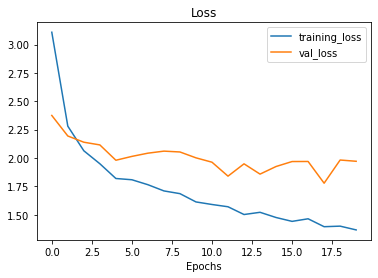

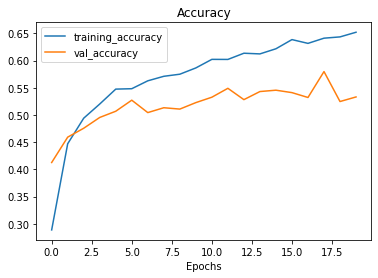

In [ ]:
plot_loss_curves(resnet_history)

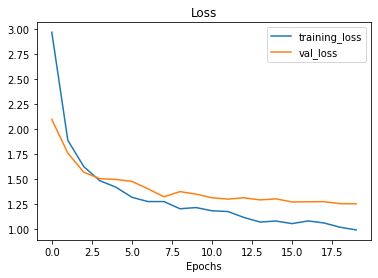

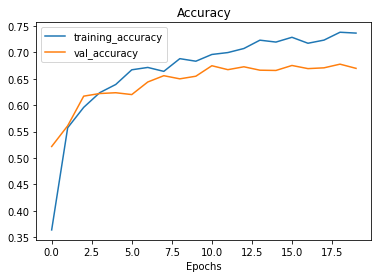

In [ ]:
plot_loss_curves(inception_history)

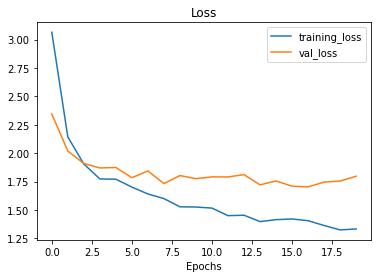

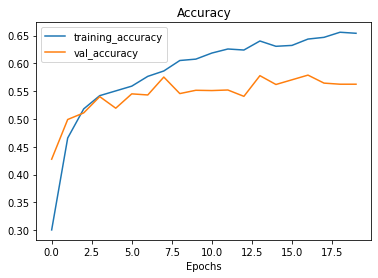

In [ ]:
plot_loss_curves(mobilenet_history)

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 101)               206949    
                                                                 
Total params: 23,771,749
Trainable params: 206,949
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
inception_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,945
Trainable params: 129,381
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             2257984   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 2,387,365
Trainable params: 129,381
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
resnet_model.save('/content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/resnet.h5')
mobilenet_model.save('/content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/mobilenet.h5')
inception_model.save('/content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/inception.h5')

# tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ML Deep Understandings/inception.h5')

In [ ]:
resnet_model.evaluate(train_data)

2525/2525 [==============================] - 533s 211ms/step - loss: 1.3289 - accuracy: 0.6597


[1.32887864112854, 0.6597153544425964]

In [ ]:
resnet_model.evaluate(val_data)

632/632 [==============================] - 139s 220ms/step - loss: 1.9281 - accuracy: 0.5453


[1.9280933141708374, 0.5453465580940247]

In [ ]:
inception_model.evaluate(train_data)

2525/2525 [==============================] - 471s 186ms/step - loss: 0.9863 - accuracy: 0.7442


[0.9863223433494568, 0.7442203164100647]

In [ ]:
inception_model.evaluate(val_data)

632/632 [==============================] - 116s 183ms/step - loss: 1.2427 - accuracy: 0.6796


[1.242732048034668, 0.6795544624328613]

In [ ]:
mobilenet_model.evaluate(train_data)

2525/2525 [==============================] - 457s 181ms/step - loss: 1.3168 - accuracy: 0.6582


[1.3167927265167236, 0.6582054495811462]

In [ ]:
mobilenet_model.evaluate(val_data)

632/632 [==============================] - 114s 180ms/step - loss: 1.7483 - accuracy: 0.5701


[1.7483057975769043, 0.5701485276222229]

#sdsacafaefa

In [ ]:
model_1 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2'
model_2 = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
model_3 = 'https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1'
model_4 = 'https://tfhub.dev/tensorflow/efficientnet/lite3/feature-vector/2'
model_5 = 'https://tfhub.dev/tensorflow/efficientnet/lite4/feature-vector/2'
model_6 = 'https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1'
model_7 = 'https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1'
model_8 = 'https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1'
model_9 = 'https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1'
model_10 = 'https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1'
model_11 = 'https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1'
# model_12 = 'https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1'
# model_13 = 'https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1'
# model_14 = 'https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1'
# model_15 = 'https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1'
model_16 = 'https://tfhub.dev/tensorflow/efficientnet/lite1/feature-vector/2'
model_17 = 'https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2'
model_18 = 'https://tfhub.dev/tensorflow/efficientnet/lite2/feature-vector/2'
model_19 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2'
model_20 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2'
model_21 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2'
model_22 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2'
model_23 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2'
model_24 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2'
model_25 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2'
model_26 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2'
model_27 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2'
model_28 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2'
model_29 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2'
model_30 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2'
model_31 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2'
model_32 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2'
model_33 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2'
model_34 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2'
model_35 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2'
model_36 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2'
model_37 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2'



adcadcdacamkmmjkk,,klnl kkl..ksvs
vacaeflnlnlnk25686512652655315zvd

my_model = create_model(model_37)
my_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
model_1 = my_model.fit(train_data,
                      epochs=10,
                      steps_per_epoch=len(train_data)//10,
                      validation_data=val_data,
                      validation_steps=len(val_data)//10)

Epoch 1/10
252/252 [==============================] - 515s 2s/step - loss: 1.8625 - accuracy: 0.5747 - val_loss: 1.1237 - val_accuracy: 0.7098
Epoch 2/10
252/252 [==============================] - 470s 2s/step - loss: 0.9535 - accuracy: 0.7522 - val_loss: 0.9598 - val_accuracy: 0.7624
Epoch 3/10
252/252 [==============================] - 471s 2s/step - loss: 0.8702 - accuracy: 0.7752 - val_loss: 0.9222 - val_accuracy: 0.7698
Epoch 4/10
252/252 [==============================] - 472s 2s/step - loss: 0.8011 - accuracy: 0.7915 - val_loss: 0.8531 - val_accuracy: 0.8001
Epoch 5/10
252/252 [==============================] - 472s 2s/step - loss: 0.7816 - accuracy: 0.7994 - val_loss: 0.9336 - val_accuracy: 0.7644
Epoch 6/10
252/252 [==============================] - 472s 2s/step - loss: 0.7719 - accuracy: 0.8048 - val_loss: 0.9121 - val_accuracy: 0.7758
Epoch 7/10
252/252 [==============================] - 472s 2s/step - loss: 0.7210 - accuracy: 0.8160 - val_loss: 0.8942 - val_accuracy: 0.7892

632/632 [==============================] - 947s 1s/step - loss: 0.8785 - accuracy: 0.7925
[0.8785444498062134, 0.7924752235412598]


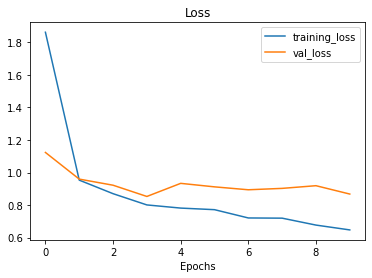

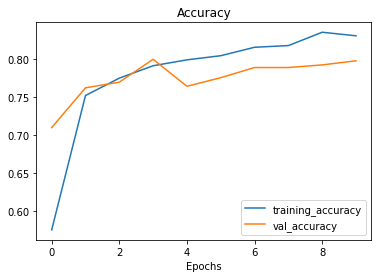

In [ ]:
# 37
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 120s 190ms/step - loss: 1.3715 - accuracy: 0.6779
[1.3715182542800903, 0.6778712868690491]


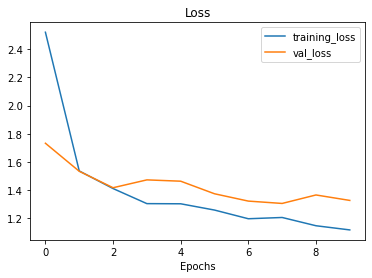

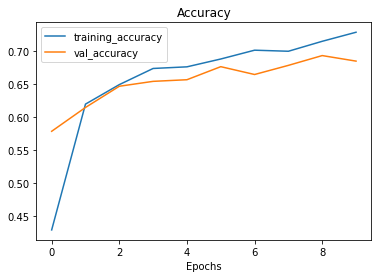

In [ ]:
# 36
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 120s 190ms/step - loss: 1.2798 - accuracy: 0.6732
[1.2798429727554321, 0.6732178330421448]


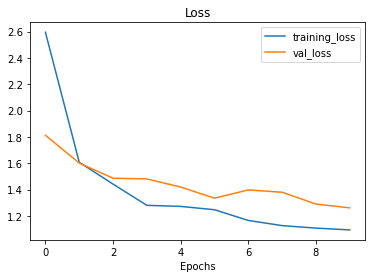

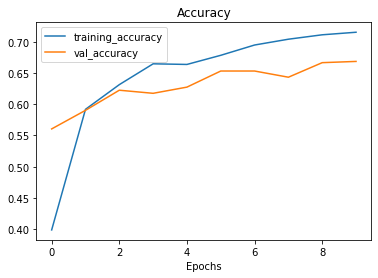

In [ ]:
# 35
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 209s 331ms/step - loss: 0.9810 - accuracy: 0.7618
[0.981020450592041, 0.761782169342041]


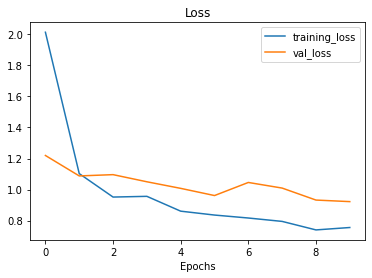

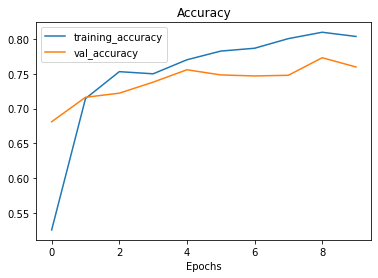

In [ ]:
# 34
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 378s 597ms/step - loss: 1.7569 - accuracy: 0.5612
[1.7568720579147339, 0.5611881017684937]


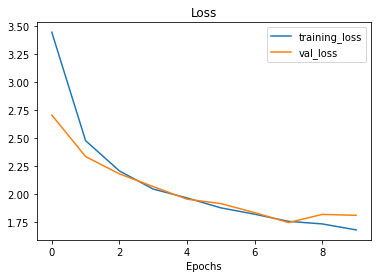

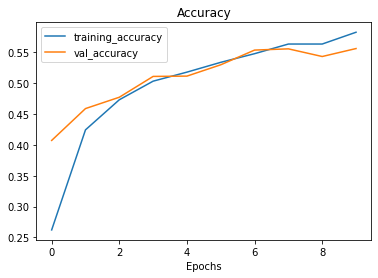

In [ ]:
# 33
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 210s 331ms/step - loss: 1.0924 - accuracy: 0.7169
[1.0924071073532104, 0.7169306874275208]


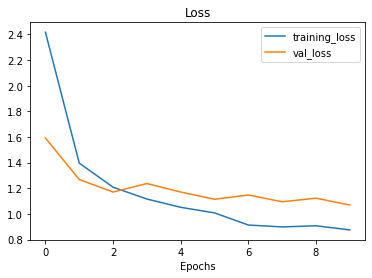

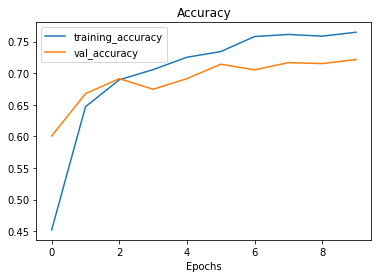

In [ ]:
# 32
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 165s 261ms/step - loss: 1.4926 - accuracy: 0.6184
[1.492621660232544, 0.6184158325195312]


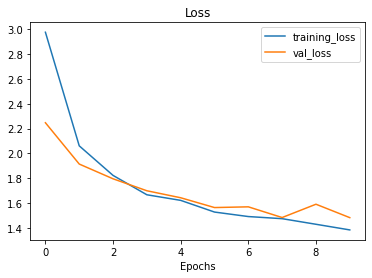

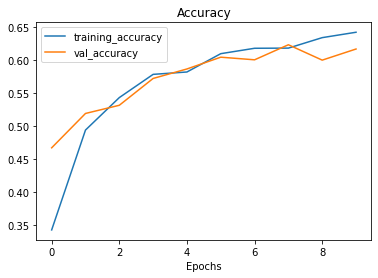

In [ ]:
# 31
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 124s 195ms/step - loss: 1.6508 - accuracy: 0.5812
[1.6508127450942993, 0.5811881422996521]


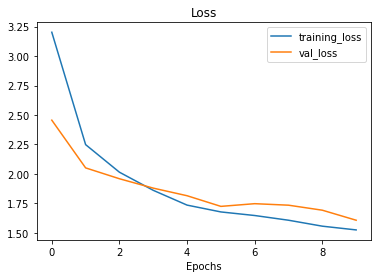

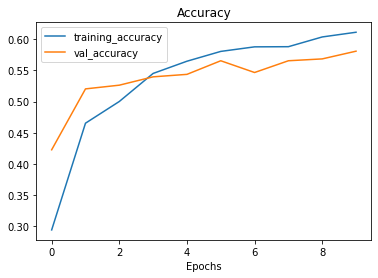

In [ ]:
# 30
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 510s 806ms/step - loss: 0.8772 - accuracy: 0.7885
[0.8771992921829224, 0.7885148525238037]


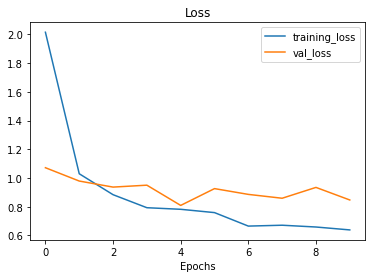

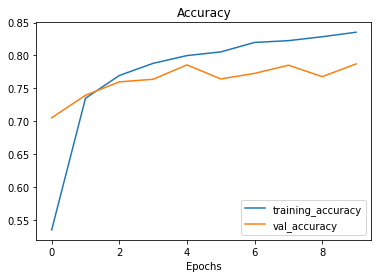

In [ ]:
# 29
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 139s 219ms/step - loss: 1.6549 - accuracy: 0.5779
[1.654875636100769, 0.5779207944869995]


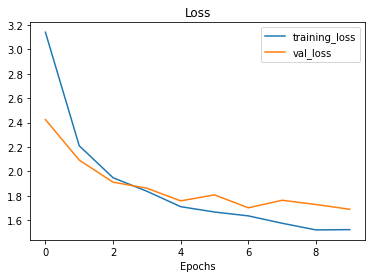

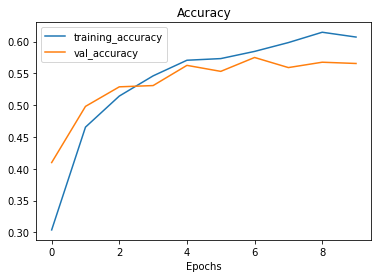

In [ ]:
# 28
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 129s 205ms/step - loss: 1.3406 - accuracy: 0.6973
[1.3406052589416504, 0.6973267197608948]


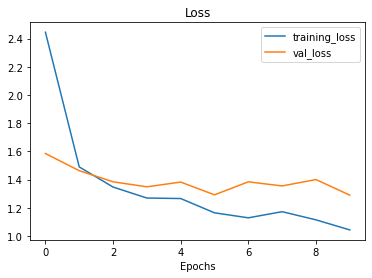

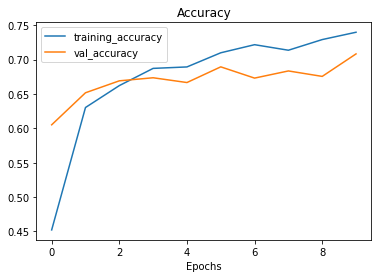

In [ ]:
# 27
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 506s 799ms/step - loss: 0.9511 - accuracy: 0.7509
[0.9511491656303406, 0.7508910894393921]


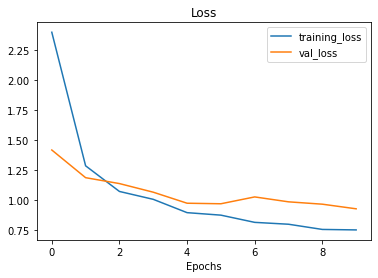

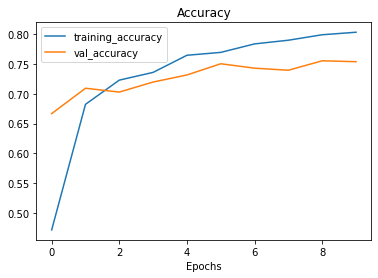

In [ ]:
# 26
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 507s 802ms/step - loss: 1.7416 - accuracy: 0.5660
[1.7415934801101685, 0.5659900903701782]


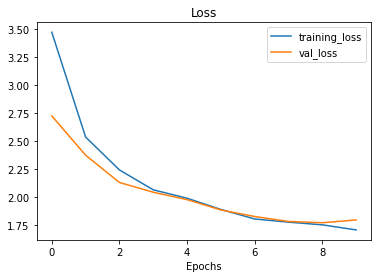

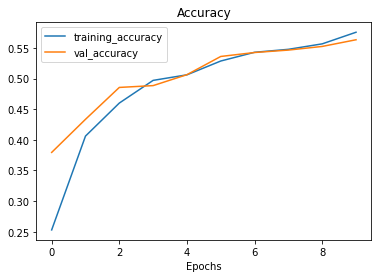

In [ ]:
# 25
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 121s 192ms/step - loss: 1.1991 - accuracy: 0.6908
[1.1990755796432495, 0.6907920837402344]


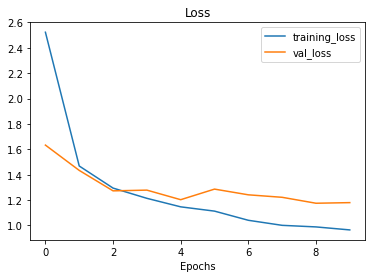

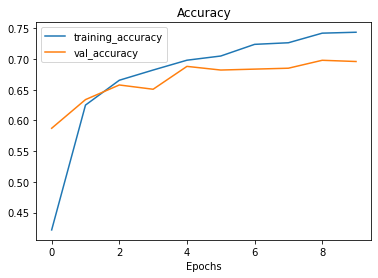

In [ ]:
# 24
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 140s 221ms/step - loss: 1.3364 - accuracy: 0.7148
[1.3363782167434692, 0.7147524952888489]


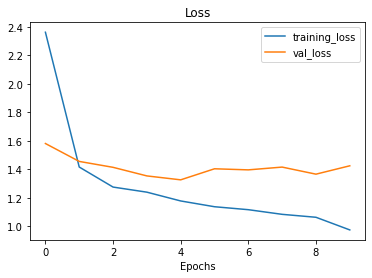

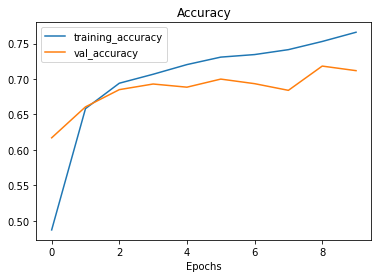

In [ ]:
# 23
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 942s 1s/step - loss: 0.9650 - accuracy: 0.7496
[0.9649835824966431, 0.749554455280304]


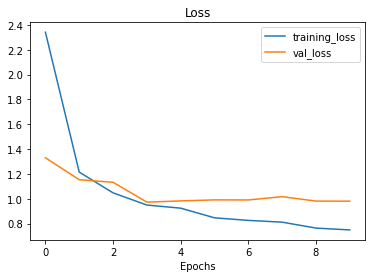

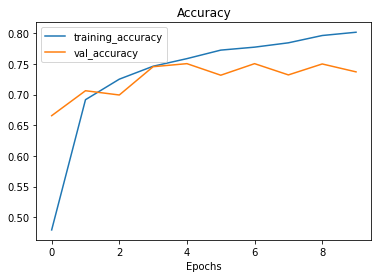

In [ ]:
# 22
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 152s 241ms/step - loss: 1.1826 - accuracy: 0.7116
[1.1825741529464722, 0.7116336822509766]


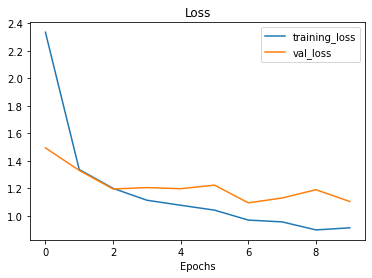

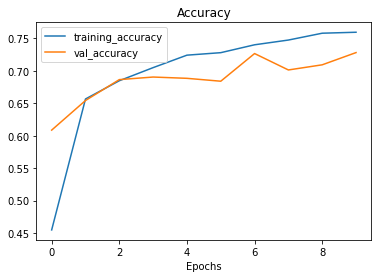

In [ ]:
# 21
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 375s 593ms/step - loss: 0.9496 - accuracy: 0.7717
[0.9496256113052368, 0.7717326879501343]


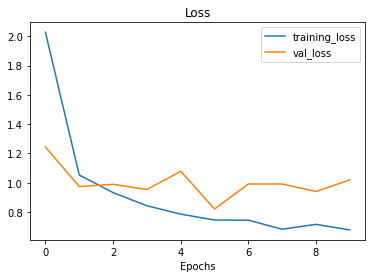

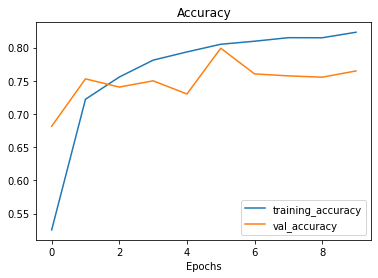

In [ ]:
# 20
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 132s 209ms/step - loss: 1.2582 - accuracy: 0.6842
[1.2582391500473022, 0.684158444404602]


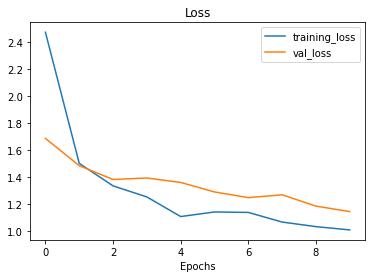

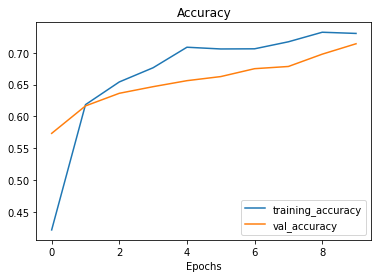

In [ ]:
# 19
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 130s 205ms/step - loss: 1.5055 - accuracy: 0.6113
[1.5054987668991089, 0.6112871170043945]


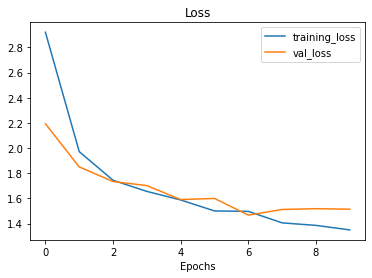

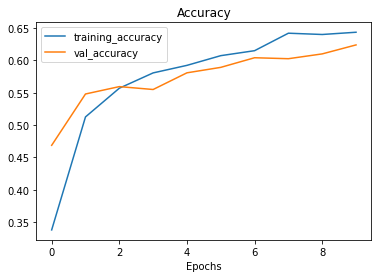

In [ ]:
# 18
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 129s 205ms/step - loss: 1.4704 - accuracy: 0.6227
[1.4703614711761475, 0.6227227449417114]


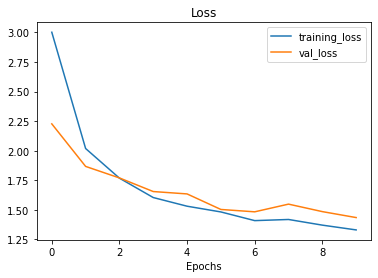

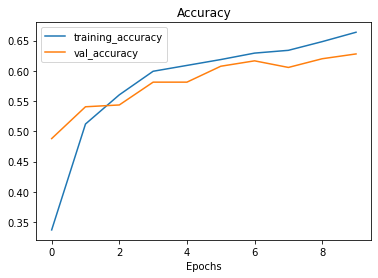

In [ ]:
# 16
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 141s 223ms/step - loss: 1.3384 - accuracy: 0.6506
[1.3383922576904297, 0.6505940556526184]


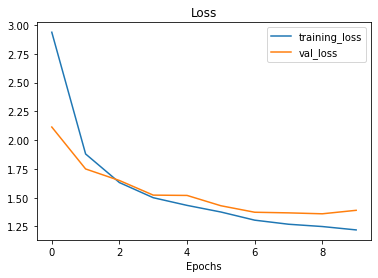

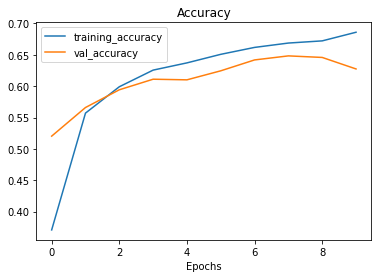

In [ ]:
# 14
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 143s 226ms/step - loss: 1.3098 - accuracy: 0.6604
[1.309777855873108, 0.6604455709457397]


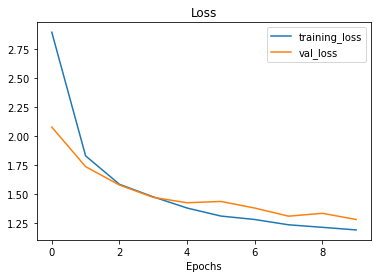

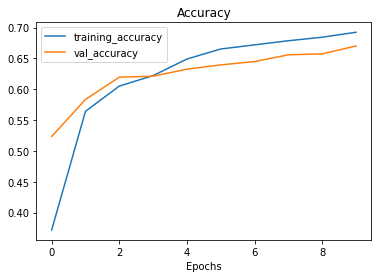

In [ ]:
# 13
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 440s 696ms/step - loss: 1.5287 - accuracy: 0.6064
[1.5286805629730225, 0.606386125087738]


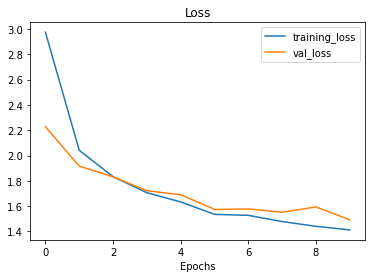

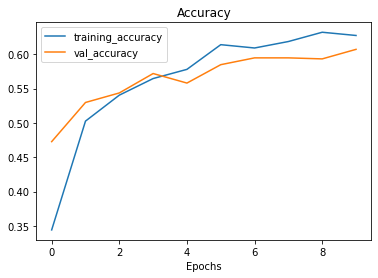

In [ ]:
# 10
print(my_model.evaluate(val_data))
plot_loss_curves(model_1)

632/632 [==============================] - 145s 230ms/step - loss: 1.3363 - accuracy: 0.6533
[1.3362581729888916, 0.6532673239707947]


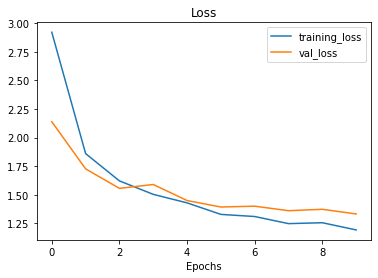

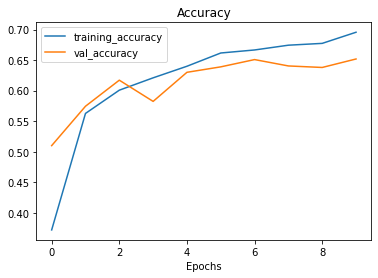

In [ ]:
# 8
print(inception_model.evaluate(val_data))
plot_loss_curves(inception_history_1)

632/632 [==============================] - 480s 759ms/step - loss: 1.4501 - accuracy: 0.6238
[1.4501495361328125, 0.6237623691558838]


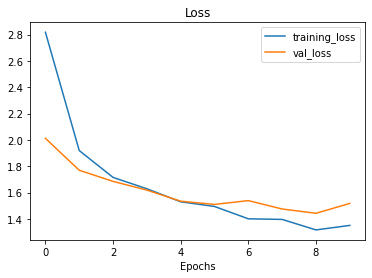

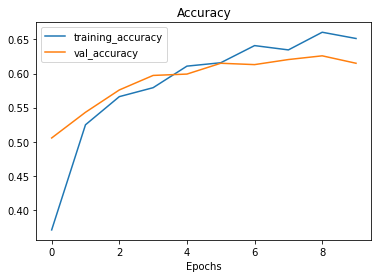

In [ ]:
# 7
print(inception_model.evaluate(val_data))
plot_loss_curves(inception_history_1)

632/632 [==============================] - 200s 317ms/step - loss: 1.4370 - accuracy: 0.6225
[1.436983346939087, 0.622475266456604]


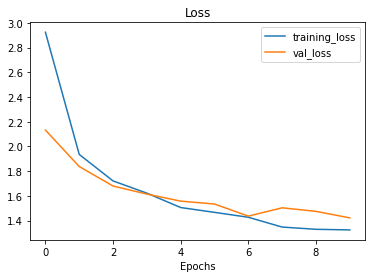

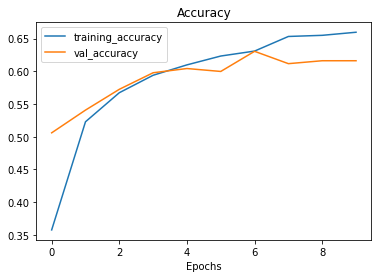

In [ ]:
# 6
print(inception_model.evaluate(val_data))
plot_loss_curves(inception_history_1)

632/632 [==============================] - 153s 241ms/step - loss: 1.7598 - accuracy: 0.5529
[1.7598137855529785, 0.5528712868690491]


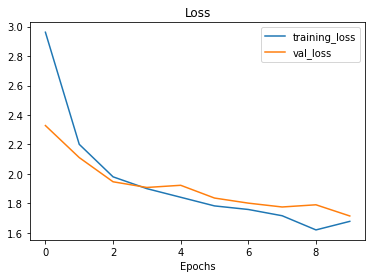

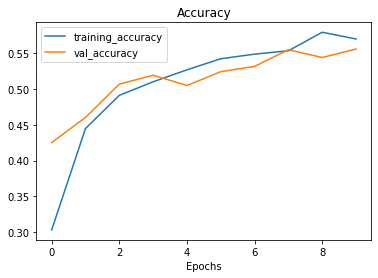

In [ ]:
# 5
print(inception_model.evaluate(val_data))
plot_loss_curves(inception_history_1)

632/632 [==============================] - 138s 218ms/step - loss: 1.5583 - accuracy: 0.5991
[1.5583300590515137, 0.5991089344024658]


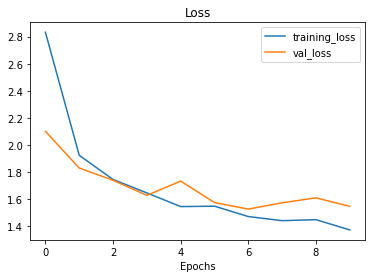

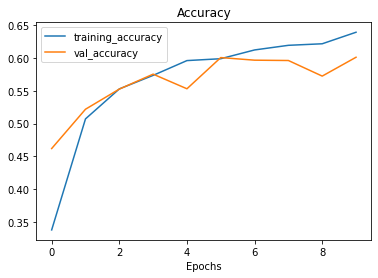

In [ ]:
# 4
print(inception_model.evaluate(val_data))
plot_loss_curves(inception_history_1)

632/632 [==============================] - 152s 240ms/step - loss: 1.3375 - accuracy: 0.6515
[1.3375487327575684, 0.6514851450920105]


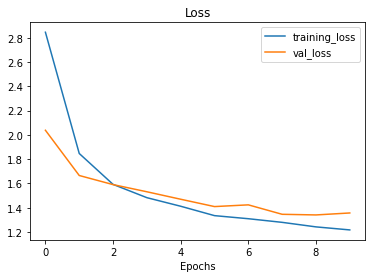

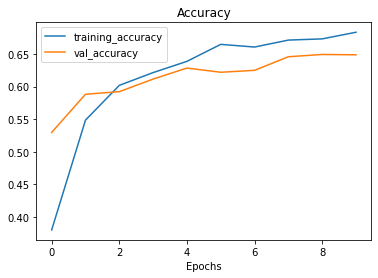

In [ ]:
# 3
print(inception_model.evaluate(val_data))
plot_loss_curves(inception_history_1)

632/632 [==============================] - 119s 189ms/step - loss: 1.3280 - accuracy: 0.6596
[1.32802414894104, 0.6595544815063477]


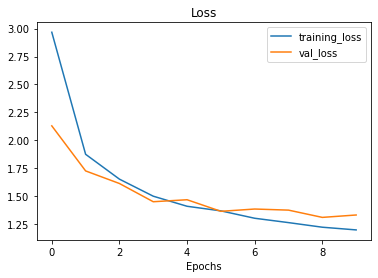

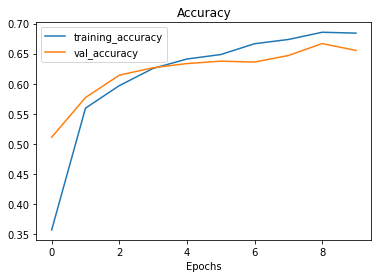

In [ ]:
# 2 
print(inception_model.evaluate(val_data))
plot_loss_curves(inception_history_1)

632/632 [==============================] - 121s 192ms/step - loss: 1.7431 - accuracy: 0.5613
[1.743086338043213, 0.5612871050834656]


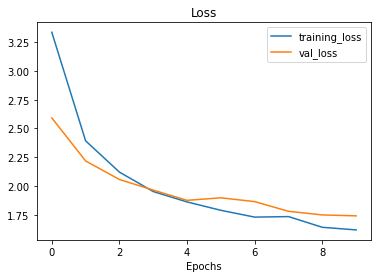

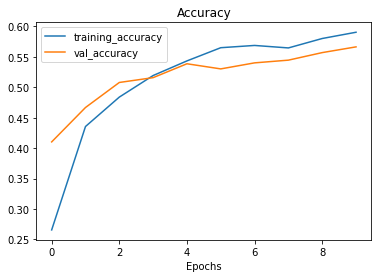

In [ ]:
# 1
print(inception_model.evaluate(val_data))
plot_loss_curves(inception_history_1)

#Compare

In [ ]:
# def f():
  # with ope
import numpy as np
import pandas as pd

In [ ]:
T=np.array([[650 ,3.3353,0.2655,0.5917,0.4102,1.6194,0.5905,1.7415,0.5665]
,[680 ,2.9673,0.3568,2.1287,0.5109,1.1966,0.6840,1.3303,0.6553]
,[750 ,2.8449,0.3802,2.0379,0.5298,1.2176,0.6834,1.3571,0.6488]
,[750 ,2.8324,0.3375,2.1004,0.4618,1.3720,0.6394,1.5462,0.6012]
,[750 ,2.9621,0.3030,2.3286,0.4251,1.6782,0.5701,1.7148,0.5561]
,[1000,2.9240,0.3576,2.1324,0.5060,1.3250,0.6596,1.4224,0.6161]
,[2400,2.8174,0.3705,2.0118,0.5055,1.3510,0.6514,1.5179,0.6151]
,[750, 2.9223,0.3719,2.1391,0.5099,1.1921,0.6956,1.3317,0.6518]
,[1400,2.9220,0.3601,2.1695,0.5015,1.3170,0.6558,1.4527,0.6215]
,[2100,2.9744,0.3441,2.2279,0.4727,1.4122,0.6274,1.4921,0.6071]
,[750 ,2.9364,0.3678,2.0789,0.5293,1.1768,0.6937,1.2758,0.6811]
,[2400,2.8084,0.3751,2.0984,0.4931,1.3316,0.6497,1.4967,0.6096]
,[800 ,2.8989,0.3718,2.0777,0.5233,1.1779,0.6923,1.2783,0.6701]
,[800 ,2.9374,0.3708,2.1138,0.5203,1.2199,0.6860,1.3902,0.6275]
,[1000,2.9073,0.3676,2.1018,0.5099,1.3314,0.6601,1.4293,0.6344]
,[650 ,3.0021,0.3372,2.2272,0.4881,1.3302,0.6638,1.4146,0.6280]
,[720 ,3.0971,0.3201,2.3031,0.4529,1.3225,0.6566,1.5933,0.5972]
,[720 ,2.9211,0.3379,2.1935,0.4688,1.3492,0.6436,1.5140,0.6240]
,[750 ,2.4750,0.4216,1.6887,0.5734,1.0108,0.7305,1.1466,0.7143]
,[1900,2.0275,0.5254,1.2441,0.6815,0.6784,0.8232,1.0203,0.7649]
,[750 ,2.3352,0.4547,1.4944,0.6086,0.9131,0.7595,1.1044,0.7282]
,[4700,2.3404,0.4794,1.3300,0.6657,0.7492,0.8017,0.9805,0.7371]
,[800 ,2.3612,0.4871,1.5803,0.6171,0.9741,0.7660,1.4240,0.7118]
,[750 ,2.5224,0.4219,1.6330,0.5873,0.9647,0.7436,1.1798,0.6959]
,[2500,3.4740,0.2529,2.7263,0.3795,1.7071,0.5758,1.7964,0.5635]
,[2500,2.3971,0.4712,1.4171,0.6667,0.7520,0.8034,0.9277,0.7540]
,[700 ,2.4454,0.4523,1.5851,0.6052,1.0430,0.7398,1.2898,0.7083]
,[750 ,3.1392,0.3038,2.4246,0.4097,1.5234,0.6070,1.6903,0.5655]
,[2600,2.0154,0.5350,1.0720,0.7054,0.6389,0.8353,0.8473,0.7872]
,[650 ,3.2020,0.2940,2.4559,0.4226,1.5246,0.6112,1.6068,0.5809]
,[800 ,2.9770,0.3428,2.2473,0.4673,1.3832,0.6425,1.4822,0.6171]
,[1050,2.4167,0.4520,1.5920,0.6007,0.8753,0.7649,1.0693,0.7217]
,[1900,3.4419,0.2623,2.7022,0.4072,1.6767,0.8525,0.8069,0.5561]
,[1050,2.0136,0.5252,1.2197,0.6811,0.7557,0.8039,0.9225,0.7599]
,[700 ,2.5954,0.3987,1.8127,0.5605,1.0931,0.7154,1.2609,0.6687]
,[700 ,2.5197,0.4284,1.7329,0.5784,1.1186,0.7289,1.3277,0.6850]
,[4700,1.8625,0.5747,1.1237,0.7098,0.6475,0.8311,0.8679,0.7981]])
df=pd.DataFrame(T, columns=['time', 'start_loss_train','start_accuracy_train','start_loss_test','start_accuracy_test', 'end_loss_train','end_accuracy_train', 'end_loss_test','end_accuracy_test'])
# df['train_acc_diff'] = df['start_loss_train'] - df['end_loss_train']
# df['train_loss_diff'] = df['end_accuracy_train'] - df['start_accuracy_train']
# df['test_acc_diff'] = df['start_loss_test'] - df['end_loss_test']
# df['test_loss_diff'] = df['end_accuracy_test'] - df['start_accuracy_test']
# df['loss_diff'] = df['end_loss_test'] - df['end_loss_train']
# df['accuracy_diff'] = df['end_accuracy_train'] - df['end_accuracy_test']

In [ ]:
df.drop(columns=['start_loss_train','start_accuracy_train','start_loss_test','start_accuracy_test'])

,time,end_loss_train,end_accuracy_train,end_loss_test,end_accuracy_test
0,650.0,1.6194,0.5905,1.7415,0.5665
1,680.0,1.1966,0.6840,1.3303,0.6553
2,750.0,1.2176,0.6834,1.3571,0.6488
3,750.0,1.3720,0.6394,1.5462,0.6012
4,750.0,1.6782,0.5701,1.7148,0.5561
5,1000.0,1.3250,0.6596,1.4224,0.6161
6,2400.0,1.3510,0.6514,1.5179,0.6151
7,750.0,1.1921,0.6956,1.3317,0.6518
8,1400.0,1.3170,0.6558,1.4527,0.6215
9,2100.0,1.4122,0.6274,1.4921,0.6071


#Compare Final 6 algorithms

In [ ]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 
mixed_precision.global_policy() # should output "mixed_float16"


<Policy "mixed_float16">

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import keras
import math
early_stopping = EarlyStopping(patience=2)

In [ ]:
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = LearningRateScheduler(step_decay)

In [ ]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))


In [ ]:
def exp_decay(epoch):
   initial_lrate = 0.1
   k = 0.1
   lrate = initial_lrate * math.exp(-k*epoch)
   return lrate

In [ ]:
loss_history = LossHistory()
lrate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, early_stopping, lrate]

In [ ]:
model_20 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2'
model_3333 = create_model(model_20)
model_3333.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adagrad(),metrics=['accuracy'])
model_3333_history = model_3333.fit(train_data, epochs=10,
                      steps_per_epoch=len(train_data),
                      validation_data=val_data,
                      validation_steps=len(val_data), 
                      callbacks=callbacks_list)

Epoch 1/10
2525/2525 [==============================] - 751s 291ms/step - loss: 1.7627 - accuracy: 0.7291 - val_loss: 1.2944 - val_accuracy: 0.7726 - lr: 0.1000
Epoch 2/10
2525/2525 [==============================] - 724s 287ms/step - loss: 0.6992 - accuracy: 0.8383 - val_loss: 1.1276 - val_accuracy: 0.7805 - lr: 0.0905
Epoch 3/10
2525/2525 [==============================] - 725s 287ms/step - loss: 0.4434 - accuracy: 0.8808 - val_loss: 1.0525 - val_accuracy: 0.7894 - lr: 0.0819
Epoch 4/10
1451/2525 [================>.............] - ETA: 4:07 - loss: 0.3014 - accuracy: 0.9140

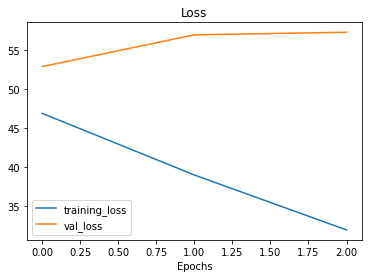

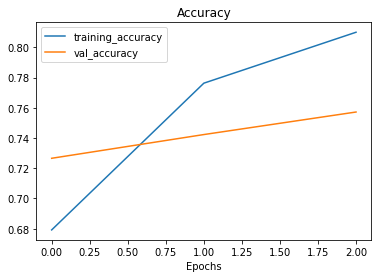

In [ ]:
plot_loss_curves(model_3333_history)

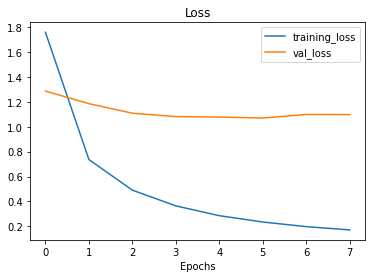

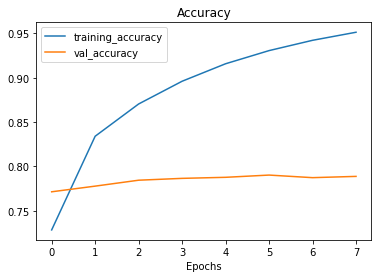

In [ ]:
plot_loss_curves(model_2222_history)

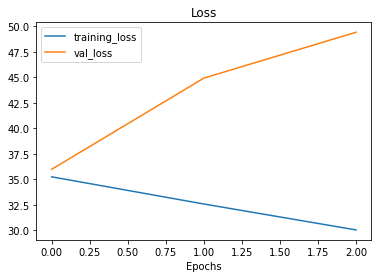

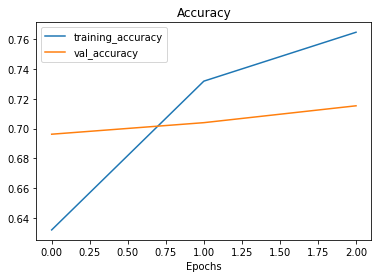

In [ ]:
plot_loss_curves(model_history)

In [ ]:
model_34 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2'

model_2 = create_model(model_34)
model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(lr=0.0001),metrics=['accuracy'])
model_2_history = model_2.fit(train_data,
                      epochs=10,
                      steps_per_epoch=len(train_data),
                      validation_data=val_data,
                      validation_steps=len(val_data))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
2525/2525 [==============================] - 829s 323ms/step - loss: 1.8722 - accuracy: 0.5629 - val_loss: 1.0721 - val_accuracy: 0.7210
Epoch 2/10
2525/2525 [==============================] - 814s 322ms/step - loss: 0.9112 - accuracy: 0.7587 - val_loss: 0.9033 - val_accuracy: 0.7609
Epoch 3/10
2525/2525 [==============================] - 814s 322ms/step - loss: 0.7714 - accuracy: 0.7925 - val_loss: 0.8436 - val_accuracy: 0.7750
Epoch 4/10
2525/2525 [==============================] - 813s 322ms/step - loss: 0.6938 - accuracy: 0.8129 - val_loss: 0.8135 - val_accuracy: 0.7841
Epoch 5/10
2525/2525 [==============================] - 813s 322ms/step - loss: 0.6396 - accuracy: 0.8258 - val_loss: 0.7980 - val_accuracy: 0.7870
Epoch 6/10
2525/2525 [==============================] - 814s 322ms/step - loss: 0.5970 - accuracy: 0.8383 - val_loss: 0.7837 - val_accuracy: 0.7918
Epoch 7/10
2525/2525 [==============================] - 813s 322ms/step - loss: 0.5621 - accuracy: 0.8472 - val_

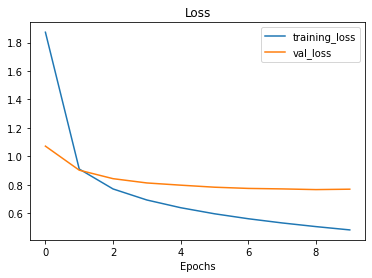

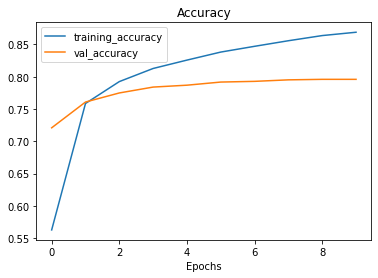

In [ ]:
plot_loss_curves(model_2_history)

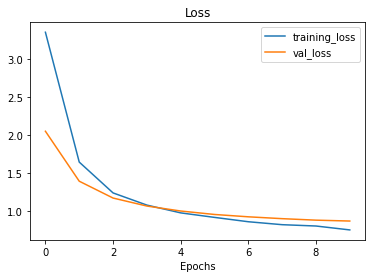

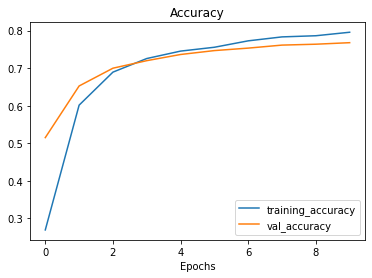

In [ ]:
plot_loss_curves(model_2_history)

In [ ]:
model_33 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2'

model_3 = create_model(model_33)
model_3.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
model_3_history = model_3.fit(train_data,
                      epochs=10,
                      steps_per_epoch=len(train_data)//4,
                      validation_data=val_data,
                      validation_steps=len(val_data)//4)

Epoch 1/10
631/631 [==============================] - 208s 289ms/step - loss: 2.8307 - accuracy: 0.3602 - val_loss: 2.2182 - val_accuracy: 0.4727
Epoch 2/10
631/631 [==============================] - 176s 278ms/step - loss: 2.0387 - accuracy: 0.5037 - val_loss: 1.9174 - val_accuracy: 0.5307
Epoch 3/10
631/631 [==============================] - 172s 272ms/step - loss: 1.8383 - accuracy: 0.5453 - val_loss: 1.8424 - val_accuracy: 0.5407
Epoch 4/10
631/631 [==============================] - 172s 272ms/step - loss: 1.7264 - accuracy: 0.5699 - val_loss: 1.7022 - val_accuracy: 0.5674
Epoch 5/10
631/631 [==============================] - 179s 284ms/step - loss: 1.6543 - accuracy: 0.5852 - val_loss: 1.7010 - val_accuracy: 0.5718
Epoch 6/10
631/631 [==============================] - 171s 271ms/step - loss: 1.5776 - accuracy: 0.6021 - val_loss: 1.6790 - val_accuracy: 0.5750
Epoch 7/10
631/631 [==============================] - 171s 271ms/step - loss: 1.5433 - accuracy: 0.6096 - val_loss: 1.6588 -

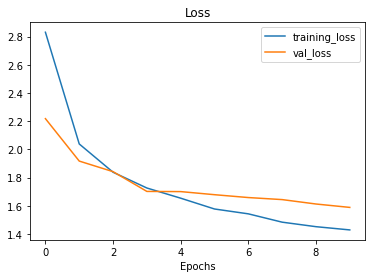

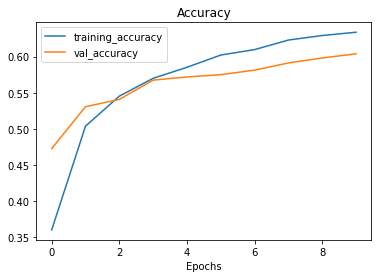

In [ ]:
plot_loss_curves(model_3_history)

In [ ]:
model_29 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2'


model_4 = create_model(model_29)
model_4.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
model_4_history = model_4.fit(train_data,
                      epochs=10,
                      steps_per_epoch=len(train_data)//4,
                      validation_data=val_data,
                      validation_steps=len(val_data)//4)

Epoch 1/10
631/631 [==============================] - 326s 480ms/step - loss: 1.4153 - accuracy: 0.6553 - val_loss: 0.9780 - val_accuracy: 0.7559
Epoch 2/10
631/631 [==============================] - 300s 475ms/step - loss: 0.8153 - accuracy: 0.7876 - val_loss: 0.9100 - val_accuracy: 0.7783
Epoch 3/10
631/631 [==============================] - 300s 475ms/step - loss: 0.7253 - accuracy: 0.8101 - val_loss: 0.8785 - val_accuracy: 0.7805
Epoch 4/10
631/631 [==============================] - 300s 475ms/step - loss: 0.6595 - accuracy: 0.8266 - val_loss: 0.9238 - val_accuracy: 0.7755
Epoch 5/10
631/631 [==============================] - 300s 475ms/step - loss: 0.6235 - accuracy: 0.8405 - val_loss: 0.8412 - val_accuracy: 0.7937
Epoch 6/10
631/631 [==============================] - 300s 476ms/step - loss: 0.5701 - accuracy: 0.8476 - val_loss: 0.9037 - val_accuracy: 0.7911
Epoch 7/10
631/631 [==============================] - 300s 475ms/step - loss: 0.5552 - accuracy: 0.8530 - val_loss: 0.9242 -

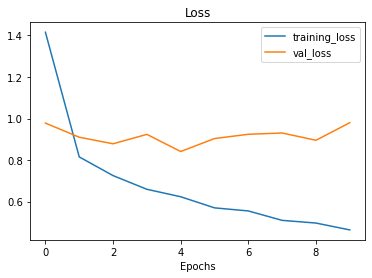

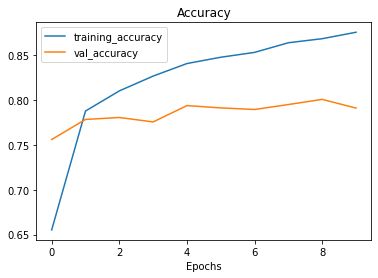

In [ ]:
plot_loss_curves(model_4_history)

In [ ]:
model_22 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2'
model_5 = create_model(model_22)
model_5.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
model_5_history = model_5.fit(train_data,
                      epochs=10,
                      steps_per_epoch=len(train_data)//4,
                      validation_data=val_data,
                      validation_steps=len(val_data)//4)

Epoch 1/10
631/631 [==============================] - 472s 703ms/step - loss: 1.6542 - accuracy: 0.6077 - val_loss: 1.0619 - val_accuracy: 0.7243
Epoch 2/10
631/631 [==============================] - 440s 698ms/step - loss: 0.9750 - accuracy: 0.7467 - val_loss: 0.9837 - val_accuracy: 0.7423
Epoch 3/10
631/631 [==============================] - 440s 698ms/step - loss: 0.8479 - accuracy: 0.7752 - val_loss: 0.9762 - val_accuracy: 0.7462
Epoch 4/10
631/631 [==============================] - 440s 698ms/step - loss: 0.7717 - accuracy: 0.7933 - val_loss: 0.9862 - val_accuracy: 0.7484
Epoch 5/10
631/631 [==============================] - 440s 698ms/step - loss: 0.7318 - accuracy: 0.8028 - val_loss: 0.8961 - val_accuracy: 0.7670
Epoch 6/10
631/631 [==============================] - 440s 698ms/step - loss: 0.6643 - accuracy: 0.8226 - val_loss: 0.9563 - val_accuracy: 0.7455
Epoch 7/10
631/631 [==============================] - 440s 697ms/step - loss: 0.6678 - accuracy: 0.8231 - val_loss: 0.9389 -

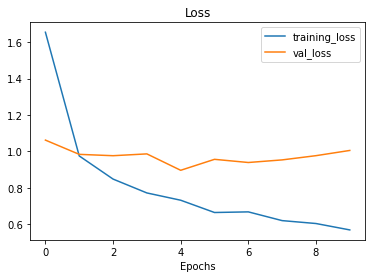

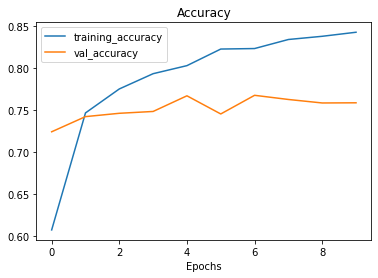

In [ ]:
plot_loss_curves(model_5_history)

In [ ]:
model_20 = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2'

model_6 = create_model(model_20)
model_6.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
model_6_history = model_6.fit(train_data,
                      epochs=10,
                      steps_per_epoch=len(train_data)//4,
                      validation_data=val_data,
                      validation_steps=len(val_data)//4)

Epoch 1/10
631/631 [==============================] - 202s 296ms/step - loss: 1.4446 - accuracy: 0.6492 - val_loss: 1.0236 - val_accuracy: 0.7383
Epoch 2/10
631/631 [==============================] - 184s 291ms/step - loss: 0.8435 - accuracy: 0.7781 - val_loss: 0.9920 - val_accuracy: 0.7540
Epoch 3/10
631/631 [==============================] - 183s 290ms/step - loss: 0.7599 - accuracy: 0.8055 - val_loss: 0.9619 - val_accuracy: 0.7634
Epoch 4/10
631/631 [==============================] - 184s 291ms/step - loss: 0.7103 - accuracy: 0.8130 - val_loss: 0.9701 - val_accuracy: 0.7633
Epoch 5/10
631/631 [==============================] - 183s 291ms/step - loss: 0.6493 - accuracy: 0.8282 - val_loss: 0.9491 - val_accuracy: 0.7702
Epoch 6/10
631/631 [==============================] - 184s 291ms/step - loss: 0.6021 - accuracy: 0.8419 - val_loss: 0.9117 - val_accuracy: 0.7775
Epoch 7/10
631/631 [==============================] - 183s 290ms/step - loss: 0.6085 - accuracy: 0.8422 - val_loss: 0.9587 -

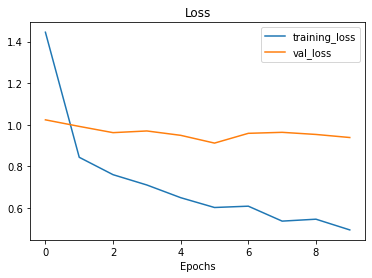

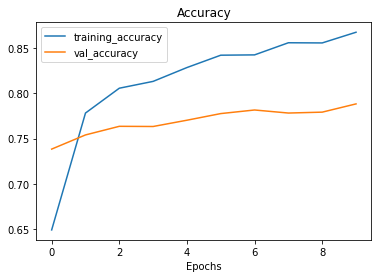

In [ ]:
plot_loss_curves(model_6_history)